# Subsetting Dataset Stored in AWS with OPeNDAP

This notebook was developed following the workflow defined in Mike Gangl's "MUR-OPeNDAP" notebook, located here: https://github.com/podaac/tutorials/blob/master/notebooks/opendap/MUR-OPeNDAP.ipynb
<br/>
while also using code from Jack McNelis's "Co-locate satellite and in-situ data for cross-validation" file, located here: https://github.com/podaac/tutorials/blob/master/notebooks/SWOT-EA-2021/Colocate_satellite_insitu_ocean.ipynb

**Goal**
<br/>
To access the MUR 1-km dataset stored on Amazon Web Services (AWS), to spatially and temporally subset it using OPeNDAC, and to download that subset to the local machine.

**Dataset**
<br/>
MUR 1-km L4 SST (requires AWS early access in order to view on Earthdata Search) https://podaac.jpl.nasa.gov/MEaSUREs-MUR?tab=background&sections=about%2Bdata

### Import Modules

In [1]:
from netCDF4 import Dataset
from urllib import request, parse
from platform import system
from os.path import join, expanduser, basename
from getpass import getpass
from netrc import netrc
from http.cookiejar import CookieJar
import xarray as xr
import dask
import requests
import json
import os

### Set the CMR, URS, and Harmony Endpoints
<br/>
CMR, or the Earthdata Common Metadata Repository, is a high-performance, high-quality, continuously evolving metadata system that catalogs Earth Science data and associated service metadata records. URS is the Earthdata login system, that allows (free) download access to Earthdata data. Harmony API allows you to seamlessly analyze Earth observation data from different NASA data centers.

In [ ]:
cmr = "cmr.earthdata.nasa.gov"
urs = "urs.earthdata.nasa.gov"
harmony = "harmony.earthdata.nasa.gov"

cmr, urs, harmony

### Earthdata Login
<br/>
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

The setup_earthdata_login_auth function will allow Python scripts to log into any Earthdata Login application programmatically. To avoid being prompted for credentials every time you run and also allow clients such as curl to log in, you can add the following to a .netrc (_netrc on Windows) file in your home directory:

    machine urs.earthdata.nasa.gov
    login <your username>
    password <your password>

Make sure that this file is only readable by the current user or you will receive an error stating "netrc access too permissive."

    $ chmod 0600 ~/.netrc

In [2]:
TOKEN_DATA = ("<token>"
              "<username>%s</username>"
              "<password>%s</password>"
              "<client_id>PODAAC CMR Client</client_id>"
              "<user_ip_address>%s</user_ip_address>"
              "</token>")


def setup_earthdata_login_auth(urs: str='urs.earthdata.nasa.gov', cmr: str='cmr.earthdata.nasa.gov'):

    # GET URS LOGIN INFO FROM NETRC OR USER PROMPTS:
    netrc_name = "_netrc" if system()=="Windows" else ".netrc"
    try:
        username, _, password = netrc(file=join(expanduser('~'), netrc_name)).authenticators(urs)
        print("# Your URS credentials were securely retrieved from your .netrc file.")
    except (FileNotFoundError, TypeError):
        print('# Please provide your Earthdata Login credentials for access.')
        print('# Your info will only be passed to %s and will not be exposed in Jupyter.' % (urs))
        username = input('Username: ')
        password = getpass('Password: ')

    # SET UP URS AUTHENTICATION FOR HTTP DOWNLOADS:
    manager = request.HTTPPasswordMgrWithDefaultRealm()
    manager.add_password(None, urs, username, password)
    auth = request.HTTPBasicAuthHandler(manager)
    jar = CookieJar()
    processor = request.HTTPCookieProcessor(jar)
    opener = request.build_opener(auth, processor)
    request.install_opener(opener)

    # GET TOKEN TO ACCESS RESTRICTED CMR METADATA:
    ip = requests.get("https://ipinfo.io/ip").text.strip()
    r = requests.post(
        url="https://%s/legacy-services/rest/tokens" % cmr,
        data=TOKEN_DATA % (str(username), str(password), ip),
        headers={'Content-Type': 'application/xml', 'Accept': 'application/json'}
    )
    return r.json()['token']['id']


# Provide URS credentials for HTTP download auth & CMR token retrieval:
_token = setup_earthdata_login_auth(urs=urs, cmr=cmr)

Username: Matthew.A.Thompson
Password: ········


### Period and Region of Interest

In [3]:
start_date = "2019-01-01"
end_date   = "2019-02-01"

minlon = -160
minlat = 18
maxlon = -150
maxlat = 24

### Find Dataset Concept-Id
<br/>
OPeNDAC requires a dataset identifier that we must obtain from the Common Metadata Repository (CMR). In the next cell, submit a request to the CMR to grab the metadata for to the dataset/collection.

In [4]:
mur_results = requests.get(
    url='https://cmr.earthdata.nasa.gov/search/collections.umm_json', 
    params={'provider': "POCLOUD",
            'ShortName': "MUR-JPL-L4-GLOB-v4.1",
            'token': _token}
).json()

# Select the first/only record in the JSON response:
mur_coll = mur_results['items'][0]

# Select the 'concept-id' from the 'meta' dictionary:
mur_ccid = mur_coll['meta']['concept-id']

mur_ccid

'C1996881146-POCLOUD'

### Find Granule URLs using CMR
<br/>
The next cell joins the base CMR url with the specified subset values in order to find matching granule URLs.

In [5]:
cmr_url = "https://cmr.earthdata.nasa.gov"
req = requests.get(cmr_url + "/search/granules.umm_json?collection_concept_id=" + 
                    mur_ccid + "&temporal=" + start_date + "T10:00:00Z," + end_date + 
                   "T00:00:00Z&pageSize=365&token=" + _token)
response_body = req.json()

Iterate through the CMR response to find OPeNDAP URLs.

In [6]:
od_files = []
for itm in response_body['items']:
    for urls in itm['umm']['RelatedUrls']:
        if 'OPeNDAP' in urls['Description']:
            od_files.append(urls['URL'])

od_files

['https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1',
 'https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/G

The number of files selected will be one more than the number of days specified due to the files being split by calander date and the data actually requested being from 9am-9am the next day.

In [7]:
len(od_files)

32

### Subsetting the Data Using OPeNDAP URLs
<br/>
We will specify the desired variables including value ranges in order to subset the data. The subsets will then be downloaded to the local machine. 
<br/>
<br/>
A single increment in value for the latitude and longitude variables represents a change of +0.01 degree. The variables ranges are as follows:

    latitude: 0...17998 (start index: -90)
    longitude: 0...35999 (start index: -180)
    time: 0...0  
    
(This program currently cannot process data at a time scale shorter than 1 day, however, it could be adjusted to do so.)
<br/>
<br/>
This following cell defines converters used to translate the user provided region values from degrees to this dataset's value ranges.

In [8]:
def latcalc(lat):
    if lat == 90:
        lat = 89.99
    if lat == -90:
        lat = -89.99
    return_lat = round((lat * 100) + 8999)
    return str(return_lat)

def loncalc(lon):
    if lon == 180:
        lon = 179.99
    return_lon = round((lon * 100) + 18000)
    return str(return_lon)

In [9]:
for f in od_files:
    print ("* Opening --> " + f)
    data_url = f'{f}.dap.nc4'
    
    # The notation below is [start index, step, end index]
    required_variables = {'analysed_sst[0:1:0][' + latcalc(minlat) + ':1:' + latcalc(maxlat) + 
                              '][' + loncalc(minlon) + ':1:' + loncalc(maxlon) + ']',
                          'analysis_error[0:1:0][' + latcalc(minlat) + ':1:' + latcalc(maxlat) + 
                              '][' + loncalc(minlon) + ':1:' + loncalc(maxlon) + ']',
                          'lat[' + latcalc(minlat) + ':1:' + latcalc(maxlat) + ']',
                          'lon[' + loncalc(minlon) + ':1:' + loncalc(maxlon) + ']',
                          'time[0:1:0]'}

    basename = os.path.basename(data_url)
    request_params = {'dap4.ce': ';'.join(required_variables)}
    
    # Identity encoding to work around an issue with server side response compression (??)
    response = requests.get(data_url, params=request_params,  headers={'Accept-Encoding': 'identity'})

    if response.ok:
        with open(basename, 'wb') as file_handler:
            file_handler.write(response.content)
    else:
        print(f'Request failed: {response.text}')

* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://opendap.earthdata.nasa.gov/providers/POCLOUD/collections/GHRSST%20Level%204%20MUR%20Global%20Foundation%20Sea%20Surface%20Temperature%20Analysis%20(v4.1)/granules/20190104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1
* Opening --> https://openda

### Plot Dataset to Confirm Subsetting 

In [10]:
mur = xr.open_mfdataset('*.dap.nc4', engine='netcdf4')

In [11]:
mur

<xarray.Dataset>
Dimensions:         (lat: 601, lon: 1001, time: 32)
Coordinates:
  * lat             (lat) float32 18.0 18.01 18.02 18.03 ... 23.98 23.99 24.0
  * lon             (lon) float32 -160.0 -160.0 -160.0 ... -150.0 -150.0 -150.0
  * time            (time) datetime64[ns] 2019-01-01T09:00:00 ... 2019-02-01T...
Data variables:
    analysed_sst    (time, lat, lon) float32 dask.array<chunksize=(1, 601, 1001), meta=np.ndarray>
    analysis_error  (time, lat, lon) float32 dask.array<chunksize=(1, 601, 1001), meta=np.ndarray>
Attributes: (12/48)
    Conventions:                CF-1.5
    title:                      Daily MUR SST, Final product
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    references:                 http://podaac.jpl.nasa.gov/Multi-scale_Ultra-...
    institution:                Jet Propulsion Laboratory
    history:                    created at nominal 4-day latency; replaced nr...
    ...                         ...
    publisher_name:             GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    publisher_email:            ghrsst-po@nceo.ac.uk
    processing_level:           L4
    cdm_data_type:              grid
    history_json:               [{"$schema":"https:\/\/harmony.earthdata.nasa...

[########################################] | 100% Completed |  0.1s


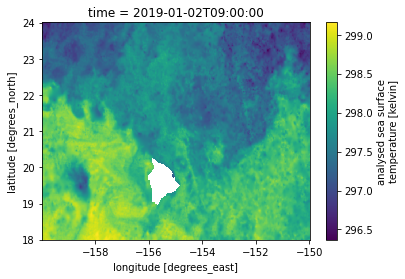

In [12]:
# Plot one time segment of data
mur['analysed_sst'].isel(time=1).plot()

This is the region we wanted!

[########################################] | 100% Completed |  0.2s


(array([5.550000e+02, 2.752000e+03, 1.063700e+04, 2.236930e+05,
        1.436783e+06, 3.879549e+06, 5.778712e+06, 4.912913e+06,
        2.560970e+06, 1.551960e+05]),
 array([294.748  , 295.19647, 295.645  , 296.0935 , 296.542  , 296.99048,
        297.439  , 297.8875 , 298.336  , 298.7845 , 299.233  ],
       dtype=float32),
 <BarContainer object of 10 artists>)

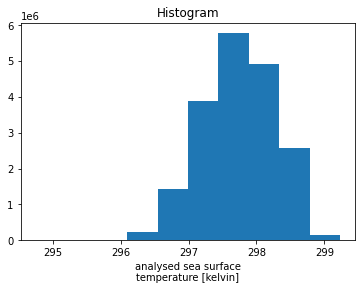

In [19]:
# Histogram
mur['analysed_sst'].plot()

[########################################] | 100% Completed |  0.1s


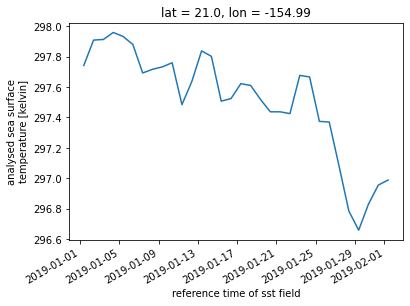

In [18]:
# Plot a single point over time (lat and lon values obtained from xarray summary statistics above)
mur['analysed_sst'].isel(lat=300, lon=500).plot()